In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil, sqrt

# 1 Least squares and linear basis functions models
## 1.1 Least squares

Reminder: Least squares is the method to find the **analytical global optimum** of $\mathcal{L}=\text{MSE}$ applied to a linear model $f(\mathbf{x}_n)=\mathbf{\tilde x}_n^\top \mathbf{w}$. That is, we don't need to use grid search or gradient descend to fit a linear model.

Using the **1st order optimality condition**:

* MSE applied to a linear model is a **convex** function
* $\mathbf{w}^\star$ such that $\vec\nabla \mathcal L(\textbf{w}^\star) = \mathbf 0$ is a **global optimium**

We recall that for MSE and a linear model: $\vec\nabla\mathcal L(\mathbf w) = -\frac{1}{N} \tilde X^\top \mathbf{e}$

We can derive from the normal equation:

$$\begin{align}
\vec\nabla\mathcal L (\textbf{w}) = 0 &\iff \tilde X^\top \mathbf e = 0\\
&\iff  \tilde X^\top (\mathbf y -  \tilde X \mathbf w) = 0\\
&\iff \tilde X^\top  \mathbf y = \tilde X^\top \tilde X \mathbf w\\
&\iff \mathbf w ^ \star = \left(\tilde X^\top \tilde X\right)^{-1} \tilde X^\top \mathbf y
\end{align}$$

which has a **unique solution $\iff$ columns of $X$ are linearly independant**.

In [3]:
def least_squares(y, tx):
    # WARNING: not robust for high condition number
    """calculate the least squares solution.
    :return: optimal w"""
    inv = np.linalg.inv(np.dot(tx.T, tx))
    return np.dot(inv, np.dot(tx.T, y))

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [4]:
from helpers import *
from time import time
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    start = time()
    w = least_squares(y, tx)
    print(f'Running least squares took {(time() - start)*1000:.4} ms')
    return w

Test it here

In [5]:
test_your_least_squares()

Running least squares took 22.59 ms


array([73.293922  , 13.47971243])

The results are the same as for gradient descent.

## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

We use the **extended features vector** $\phi(x_n) = \left[1, x_n, x_n^2, \dots, x_n^M\right]$ to create a **more powerful** linear model (the model is linear in $\phi(x_n)$, not $x_n$):

$$\begin{align}
f(x_n) &= \phi(x_n)^\top \mathbf w \\
&= \textstyle \sum_{d=0}^M (x_n)^D w_d\\
&= w_0 + w_1 x_n + w_2 x_n ^ 2 + \dots + w_M x_n^M
\end{align}$$

We want `build_poly` to build the **extended feature matrix**:

$$\mathbf{\tilde \Phi} := 
\begin{bmatrix}
\phi(x_1)\\
\vdots\\
\phi(x_N)
\end{bmatrix}$$

In [6]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [7]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    #power_mx = np.arange(degree+1, dtype=np.uint8)[None, :] * np.ones(len(x), dtype=np.uint8)[:, None]
    power_mx = np.tile(np.arange(degree + 1), (len(x), 1))
    augmented_x = np.tile(np.array(x).reshape(-1, 1), (1, degree + 1))
    return np.power(augmented_x, power_mx)

In [8]:
build_poly([-1, 1, 2], 3)

array([[ 1, -1,  1, -1],
       [ 1,  1,  1,  1],
       [ 1,  2,  4,  8]])

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [9]:
def compute_mse(y, tx, w):
    e = y - np.matmul(tx, w)
    return np.inner(e, e) / len(y) / 2

In [10]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 11, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        extended_X = build_poly(x, degree)
        weights = least_squares(y, extended_X)
        MSE = compute_mse(y, extended_X, weights)
        rmse = (2*MSE)**0.5

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.2585827766773747
Processing 3th experiment, degree=11, rmse=0.2555351522054776
Processing 4th experiment, degree=12, rmse=0.9299494097866372


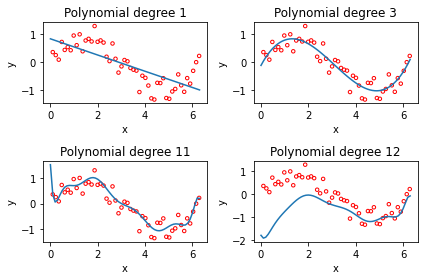

In [11]:
# linalg.solve
polynomial_regression()

Let's investigate this weird behaviour that we get with degree 12:

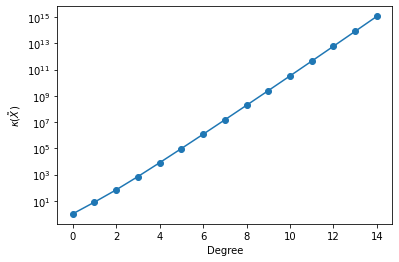

In [12]:
condition_nums = {
    degree: np.linalg.cond(build_poly(x, degree))
    for degree in range(15)
}
plt.semilogy(range(15), list(condition_nums.values()), '-o')
plt.xlabel('Degree')
plt.ylabel(r'$\kappa(\tilde X)$');

We see that the condition number $\kappa(\tilde X)$ blows up when the degree of the extended polynomial matrix increases. We should therefore use a more robust way of solving the linear system $\tilde X^\top  \mathbf y = \tilde X^\top \tilde X \mathbf w$: `np.linalg.solve`.

In [13]:
def least_squares(y, tx):
    """calculate the least squares solution. 
    Uses `linalg.solve` to increase robustness against high condition numbers.
    :return: optimal w"""
    return np.linalg.solve(tx.T.dot(tx), tx.T.dot(y))

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.2585827766773748
Processing 3th experiment, degree=11, rmse=0.24452913643990384
Processing 4th experiment, degree=12, rmse=0.24328247481248674


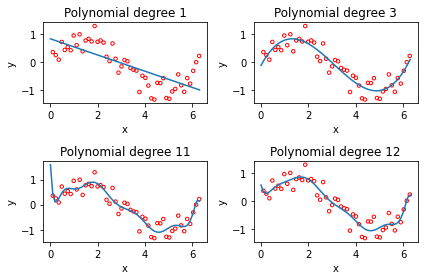

In [14]:
polynomial_regression()

Which is much better!

### Test least squares on data from ex 2

In [15]:
height, weight, _ = load_data_from_ex02(sub_sample=False)
x, _, _ = standardize(height)
y, tx = build_model_data(x, weight)

In [16]:
w_star = least_squares(y, tx)
w_star

array([73.293922  , 13.47971243])

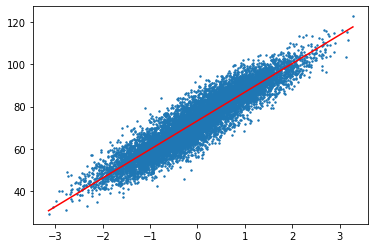

In [17]:
plt.scatter(x, y, s=2)
xgrid = np.linspace(x.min(), x.max(), 100)
plt.plot(xgrid, w_star[0] + w_star[1] * xgrid, 'r');

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [18]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    :return: (xtrain, ytrain, xtest, ytest)
    """
    N = len(x)
    # Shuffle indices
    np.random.seed(seed)
    shuffling_indices = np.random.permutation(N)
    x = x[shuffling_indices]
    y = y[shuffling_indices]
    # Split index
    sid = ceil(N * ratio)
    
    return x[:sid], y[:sid], x[sid:], y[sid:]

In [19]:
split_data(
    np.array([0, 1, 2, 3]),
    np.array([0, 1, 1, 0]),
    0.7
)

(array([3, 2, 0]), array([0, 1, 0]), array([1]), array([1]))

Then, test your `split_data` function below.

In [20]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    xtrain, ytrain, xtest, ytest = split_data(x, y, ratio, seed)
    
    xtrain_poly = build_poly(xtrain, degree)
    xtest_poly = build_poly(xtest, degree)
    
    w = least_squares(ytrain, xtrain_poly)
    
    rmse_tr = (2*compute_mse(ytrain, xtrain_poly, w)) ** 0.5
    rmse_te = (2*compute_mse(ytest, xtest_poly, w)) ** 0.5
    
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))

In [21]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=5.539, Testing RMSE=5.626
proportion=0.9, degree=3, Training RMSE=5.491, Testing RMSE=5.568
proportion=0.9, degree=7, Training RMSE=5.470, Testing RMSE=5.525
proportion=0.9, degree=12, Training RMSE=5.467, Testing RMSE=5.576
proportion=0.5, degree=1, Training RMSE=5.581, Testing RMSE=5.514
proportion=0.5, degree=3, Training RMSE=5.526, Testing RMSE=5.472
proportion=0.5, degree=7, Training RMSE=5.500, Testing RMSE=5.452
proportion=0.5, degree=12, Training RMSE=5.493, Testing RMSE=5.472
proportion=0.1, degree=1, Training RMSE=5.505, Testing RMSE=5.557
proportion=0.1, degree=3, Training RMSE=5.478, Testing RMSE=5.512
proportion=0.1, degree=7, Training RMSE=5.453, Testing RMSE=5.498
proportion=0.1, degree=12, Training RMSE=5.440, Testing RMSE=6.077


# 3 Ridge Regression
Please fill in the function below.

In [37]:
x, y = load_data()

Ridge regularization defines a special type of regularizer applied to a linear model. It helps to:

* limit overfitting
* fight ill-conditionning / collinearity problems, i.e. when columns of $X$ are almost collinear

The regularizer of ridge regression is defined as the $L_2$-norm of the weight vector:

$$\Omega(\mathbf w) = \lambda \Vert\mathbf w \Vert_2^2$$

so that the function to mininmize is 

$$\begin{align}
\mathcal P(\mathbf w) &= \mathcal L(\mathbf w) + \Omega(\mathbf w)\\
&= \frac{1}{2N} \mathbf e^\top  \mathbf e + \lambda \Vert\mathbf w \Vert_2^2
\end{align}$$

The function $\mathcal P$ is convex, so by the 1st order optimality condition:

$$\vec \nabla \mathcal P(\mathbf w) = 0 \iff \left( X^\top X + \lambda' I \right)\mathbf w = X^\top \mathbf y, \quad \lambda' = 2N \lambda$$

which always has a unique solution since the inverse of $\left( X^\top X + \lambda' I \right)$ always exist (eigenvalues are at least $\lambda' > 0$).

In [38]:
def compute_rmse(y, tX, w):
    mse = compute_mse(y, tX, w)
    return sqrt(2*mse)

In [43]:
def ridge_regression_inv(y, tx, lambda_):
    """implement ridge regression."""
    N, D = tx.shape
    inv = tx.T.dot(tx) + 2 * N * lambda_ * np.eye(D)
    inv = np.linalg.inv(inv)
    return inv.dot(tx.T).dot(y)

In [44]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    N, D = tx.shape
    left = tx.T.dot(tx) + 2 * N * lambda_ * np.eye(D)
    right = tx.T.dot(y)
    return np.linalg.solve(left, right)

In [45]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    
    xtrain, ytrain, xtest, ytest = split_data(x, y, ratio, seed)
    
    txtrain = build_poly(xtrain, degree)
    txtest = build_poly(xtest, degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        w = ridge_regression(ytrain, txtrain, lambda_)
        
        rmse_tr.append(compute_rmse(ytrain, txtrain, w))
        rmse_te.append(compute_rmse(ytest, txtest, w))
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.334
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.333
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.229, Testing RMSE=0.329
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.230, Testing RMSE=0.319
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.232, Testing RMSE=0.302
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.237, Testing RMSE=0.283
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.246, Testing RMSE=0.276
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.264, Testing RMSE=0.298
proportion=0.5, degree=7, lambda=0.193, 

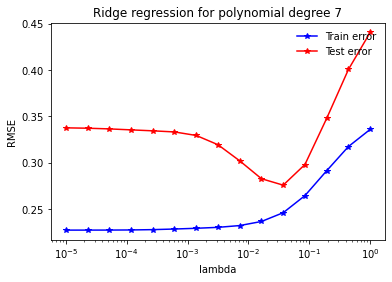

In [46]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)

# Theoretical exercises

## Condition number an ill-conditionning

The condition number of the matrix $A$ can be defined as 

$$\kappa(A) := \Vert A^{-1} \Vert \cdot \Vert A \Vert$$

where the norm of a matrix is defined in terms of a vector norm on $\mathbb R^n$:

$$
\Vert A \Vert := \sup_{\mathbf x\in \mathbb R^n,  \mathbf x \neq \mathbf 0} \frac{\Vert A\mathbf x\Vert}{\Vert \mathbf x \Vert}
$$

If $A$ is normal, then 

$$\kappa(A) = \frac{|\lambda_{max}(A)|}{|\lambda_{min}(A)|}$$

The spectral theorem states that $A$ is normal $\iff$ $A$ is diagonalizable. 

### Diagonalization

The **theorem of diagonalization** tells us that an square matrix $A \in \mathbb R^{n\times n}$ is diagonalizable $\iff$ $A$ has $n$ linearly independant eigenvectors.

Another theorem tells us that $A$ is diagonalizable $\iff$ the sum of the dimensions of the distinct eigenspaces of $A$ is equal to n, which can be formulated as:

$$A \text{ is diagonalizable} \iff \textstyle \sum_i \text{dim}\left(\text{Eig}_{\lambda_i}(A)\right) = n$$

with $\text{Eig}_{\lambda_i}(A)$ the eigenspace of $A$ for the eigenvalue $\lambda_i$:

$$\text{Eig}_{\lambda}(A) = \left\{\mathbf v \in \mathbb R ^n | A\mathbf v = \lambda \mathbf v\right\} \subseteq \mathbb R^n$$

See [here](https://math.stackexchange.com/questions/320220/intuitively-what-is-the-difference-between-eigendecomposition-and-singular-valu) to get the feeling of the difference between eigenvalue decomposition and singular value decomposiion. 

### Example - condition number



We consider a 2D linear model:

* $\mathbf w = (w_1, w_2)$
* $y = f(\mathbf x) = x_1w_1 + x_2 w_2$

The first dataset is:

$$X = \begin{bmatrix}
400 & -201 \\
-800 & 401
\end{bmatrix}, 
y = (200, -200)^\top$$

In [26]:
X = np.array([[400, -201], [-800, 401]])
y = np.array([200, -200])

In [27]:
lambdas = np.linalg.eigvals(X)
print(lambdas)
abs(lambdas.max() / lambdas.min()), np.linalg.cond(X)

[-4.99064837e-01  8.01499065e+02]


(1606.0018773357358, 2503.0046004808573)

In [28]:
np.linalg.solve(X, y)

array([-100., -200.])

We get $\mathbf w = (-100, 200)^\top$.

The second dataset is 
$$X = \begin{bmatrix}
401 & -201 \\
-800 & 401
\end{bmatrix}, 
y = (200, -200)^\top$$

In [29]:
X = np.array([[401, -201], [-800, 401]])
y = np.array([200, -200])

In [30]:
lambdas = np.abs(np.linalg.eigvals(X))
lambdas.max() / lambdas.min(), np.linalg.cond(X)

(643201.9999918083, 1002003.0000501256)

In [31]:
643201.9999918083/1606.0018773357358, 1002003.0000501256/2503.0046004808573

(400.49890916618557, 400.3200792589949)

In [32]:
np.linalg.solve(X, y)

array([40000.00000034, 79800.00000068])

We get a much bigger $\mathbf w$. Note that the condition number $\kappa(X)$ is much bigger in the second dataset.